In [1]:
# 第一步：导入所有必需的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 设置图表样式
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')

# 设置中文字体（Mac系统）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # Mac 系统可用的中文字体
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 第二步：加载数据
# 请确保数据文件放在项目的 data/ 目录下
user_df = pd.read_csv('data/tianchi_mum_baby.csv', encoding='utf-8')
trade_df = pd.read_csv('data/tianchi_mum_baby_trade_history.csv', encoding='utf-8')

# 查看数据基本信息
print("用户表信息:")
print(f"行数: {user_df.shape[0]}, 列数: {user_df.shape[1]}")
print("\n交易表信息:")
print(f"行数: {trade_df.shape[0]}, 列数: {trade_df.shape[1]}")

# 显示前几行数据
print("\n用户表前5行:")
display(user_df.head())
print("\n交易表前5行:")
display(trade_df.head())

用户表信息:
行数: 953, 列数: 3

交易表信息:
行数: 29971, 列数: 6

用户表前5行:


,user_id,birthday,gender
0,2757,20130311,1
1,415971,20121111,0
2,1372572,20120130,1
3,10339332,20110910,0
4,10642245,20130213,0



交易表前5行:


,user_id,auction_id,category_2,category_1,buy_mount,day
0,786295544,41098319944,50014866,50022520,2,20140919
1,532110457,17916191097,50011993,28,1,20131011
2,249013725,21896936223,50012461,50014815,1,20131011
3,917056007,12515996043,50018831,50014815,2,20141023
4,444069173,20487688075,50013636,50008168,1,20141103


In [3]:
# 第三步：数据清洗与预处理
# 修正字段名（根据你的数据实际情况调整）
# 注意：根据网页描述，trade_df可能有重复的字段名
print("交易表列名:", trade_df.columns.tolist())

# 如果确实有重复列名，需要重命名
if 'category_1' in trade_df.columns:
    # 假设第二个category_1应该是category_2
    trade_df.columns = ['user_id', 'auction_id', 'category_1', 'category_2', 'buy_amount', 'buy_date']
    print("已重命名列名:", trade_df.columns.tolist())

# 检查缺失值
print("\n用户表缺失值统计:")
print(user_df.isnull().sum())
print("\n交易表缺失值统计:")
print(trade_df.isnull().sum())

交易表列名: ['user_id', 'auction_id', 'category_2', 'category_1', 'buy_mount', 'day']
已重命名列名: ['user_id', 'auction_id', 'category_1', 'category_2', 'buy_amount', 'buy_date']

用户表缺失值统计:
user_id     0
birthday    0
gender      0
dtype: int64

交易表缺失值统计:
user_id       0
auction_id    0
category_1    0
category_2    0
buy_amount    0
buy_date      0
dtype: int64


In [4]:
# 第四步：数据类型转换
# 转换日期字段
user_df['birthday'] = pd.to_datetime(user_df['birthday'], format='%Y%m%d', errors='coerce')
trade_df['buy_date'] = pd.to_datetime(trade_df['buy_date'], format='%Y%m%d', errors='coerce')

# 转换性别字段为类别
gender_map = {0: '男孩', 1: '女孩', 2: '性别不明'}
user_df['gender_label'] = user_df['gender'].map(gender_map)

# 添加年龄计算
current_date = pd.to_datetime('2015-12-31')  # 假设数据截止日期
user_df['age_days'] = (current_date - user_df['birthday']).dt.days
user_df['age_months'] = user_df['age_days'] // 30

print("数据类型转换完成!")
display(user_df.head())

数据类型转换完成!


,user_id,birthday,gender,gender_label,age_days,age_months
0,2757,2013-03-11,1,女孩,1025,34
1,415971,2012-11-11,0,男孩,1145,38
2,1372572,2012-01-30,1,女孩,1431,47
3,10339332,2011-09-10,0,男孩,1573,52
4,10642245,2013-02-13,0,男孩,1051,35


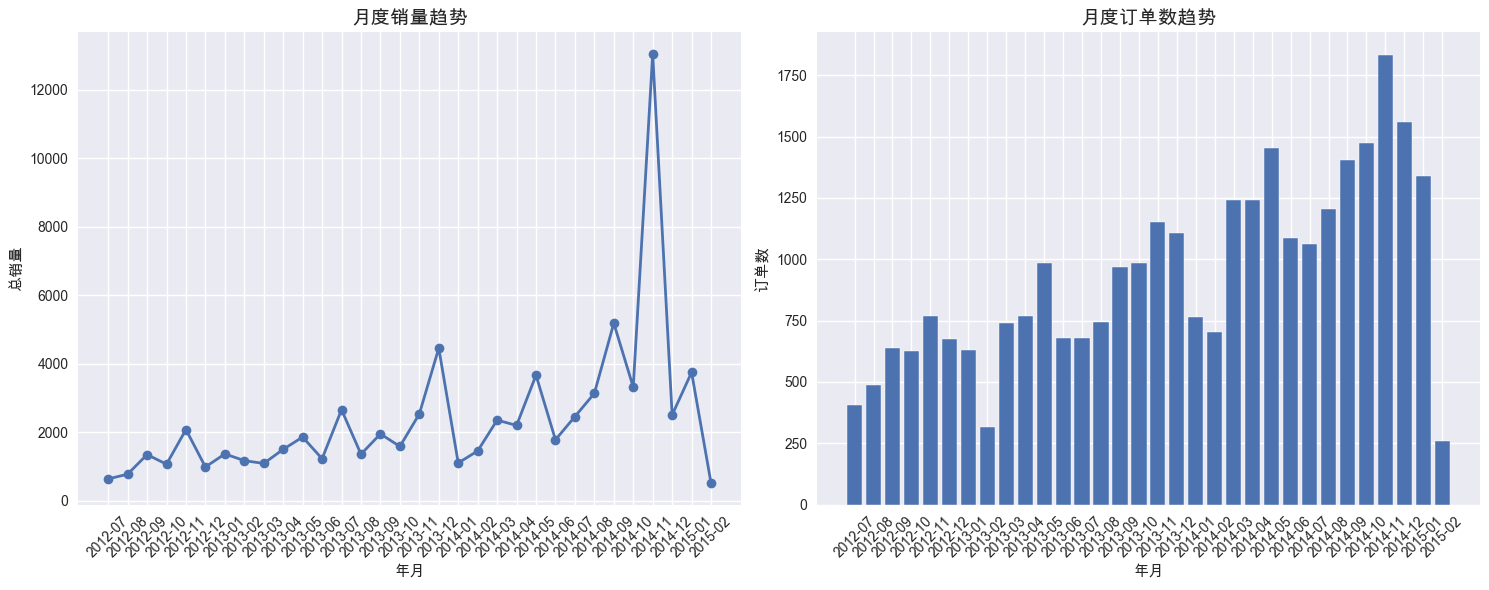

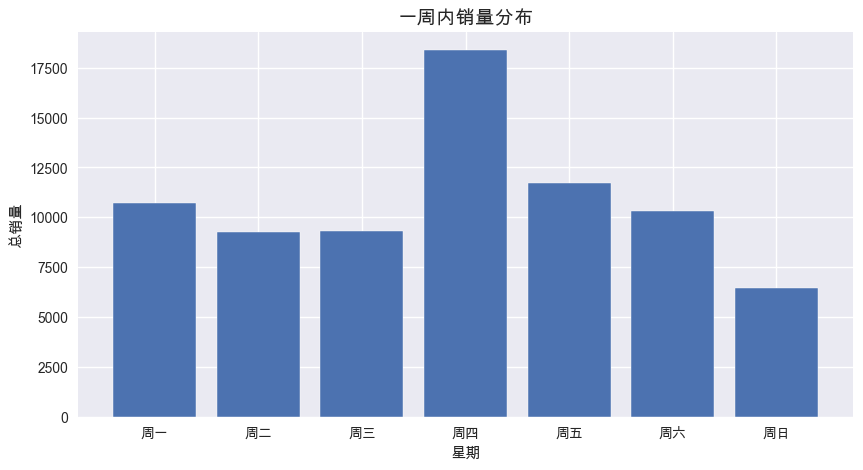

In [5]:
# 第五步：流量分析 - 按时间维度
# 创建时间维度的派生列
trade_df['year'] = trade_df['buy_date'].dt.year
trade_df['month'] = trade_df['buy_date'].dt.month
trade_df['quarter'] = trade_df['buy_date'].dt.quarter
trade_df['weekday'] = trade_df['buy_date'].dt.weekday  # 0=周一, 6=周日

# 1. 月度销售趋势分析
monthly_sales = trade_df.groupby(['year', 'month']).agg({
    'buy_amount': 'sum',
    'auction_id': 'count'
}).reset_index()
monthly_sales.columns = ['year', 'month', 'total_quantity', 'order_count']

# 创建复合月份列用于绘图
monthly_sales['year_month'] = monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str).str.zfill(2)

# 可视化
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(monthly_sales['year_month'], monthly_sales['total_quantity'], marker='o', linewidth=2)
plt.title('月度销量趋势', fontsize=14, fontweight='bold')
plt.xlabel('年月')
plt.ylabel('总销量')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(monthly_sales['year_month'], monthly_sales['order_count'])
plt.title('月度订单数趋势', fontsize=14, fontweight='bold')
plt.xlabel('年月')
plt.ylabel('订单数')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2. 周内销售模式分析
weekday_sales = trade_df.groupby('weekday').agg({
    'buy_amount': 'sum',
    'auction_id': 'count'
}).reset_index()
weekday_sales.columns = ['weekday', 'total_quantity', 'order_count']

weekday_names = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
weekday_sales['weekday_name'] = weekday_sales['weekday'].apply(lambda x: weekday_names[x])

plt.figure(figsize=(10, 5))
plt.bar(weekday_sales['weekday_name'], weekday_sales['total_quantity'])
plt.title('一周内销量分布', fontsize=14, fontweight='bold')
plt.xlabel('星期')
plt.ylabel('总销量')
plt.show()

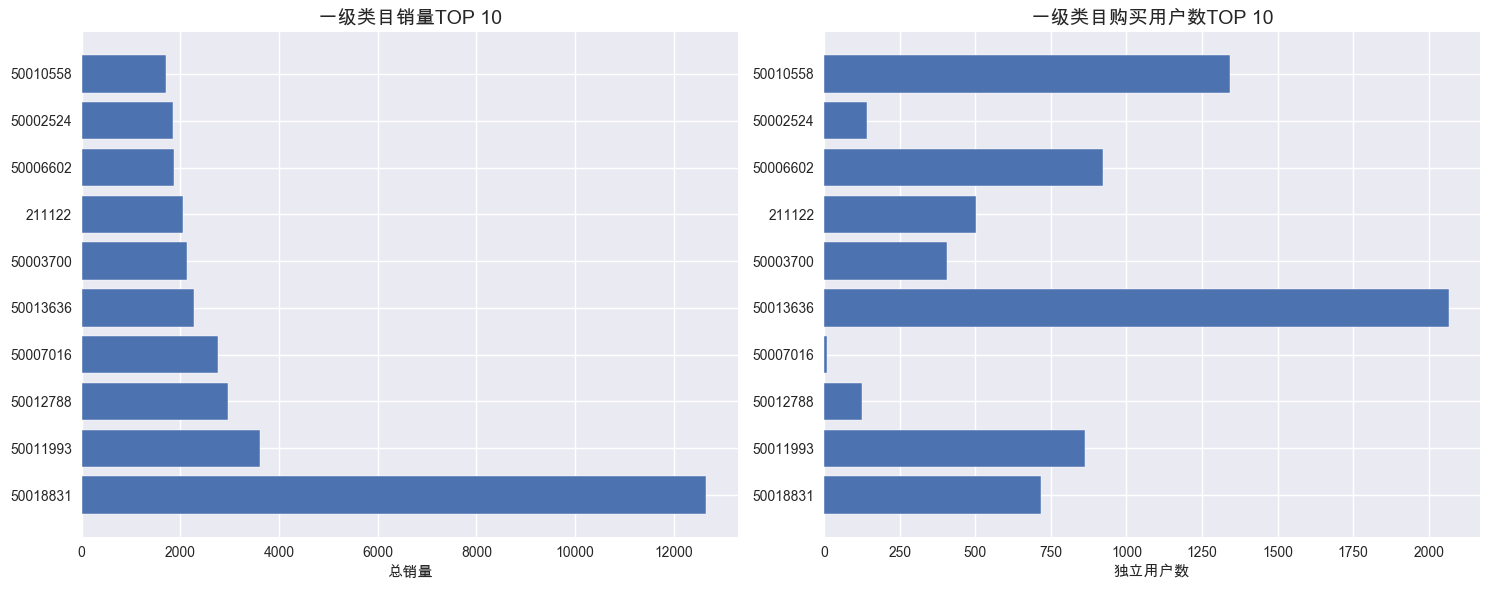

二级类目分析数据:


,category_1,category_2,buy_amount
378,50018831,50014815,12657
153,50011993,28,3609
236,50012788,28,2969
86,50007016,50008168,2759
262,50013636,50008168,2279
30,50003700,28,2145
6,211122,38,2058
71,50006602,50008168,1868
26,50002524,28,1843
141,50010558,50008168,1718


In [6]:
# 第六步：类别分析
# 1. 一级类目销售排行
if 'category_1' in trade_df.columns:
    category1_sales = trade_df.groupby('category_1').agg({
        'buy_amount': 'sum',
        'auction_id': 'count',
        'user_id': 'nunique'
    }).reset_index()
    category1_sales.columns = ['category_1', 'total_quantity', 'order_count', 'unique_users']
    
    # 排序并显示TOP 10
    top_categories = category1_sales.sort_values('total_quantity', ascending=False).head(10)
    
    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 销量排行
    axes[0].barh(top_categories['category_1'].astype(str), top_categories['total_quantity'])
    axes[0].set_title('一级类目销量TOP 10', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('总销量')
    
    # 购买用户数
    axes[1].barh(top_categories['category_1'].astype(str), top_categories['unique_users'])
    axes[1].set_title('一级类目购买用户数TOP 10', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('独立用户数')
    
    plt.tight_layout()
    plt.show()
    
    # 2. 如果有二级类目，进一步分析
    if 'category_2' in trade_df.columns:
        category2_sales = trade_df.groupby(['category_1', 'category_2']).agg({
            'buy_amount': 'sum'
        }).reset_index()
        print("二级类目分析数据:")
        display(category2_sales.sort_values('buy_amount', ascending=False).head(10))

性别维度销售分析:


,gender,total_quantity,avg_quantity,purchase_count,unique_orders,unique_users
0,女孩,559,1.276256,438,437,438
1,性别不明,44,1.692308,26,26,26
2,男孩,935,1.900407,492,491,489


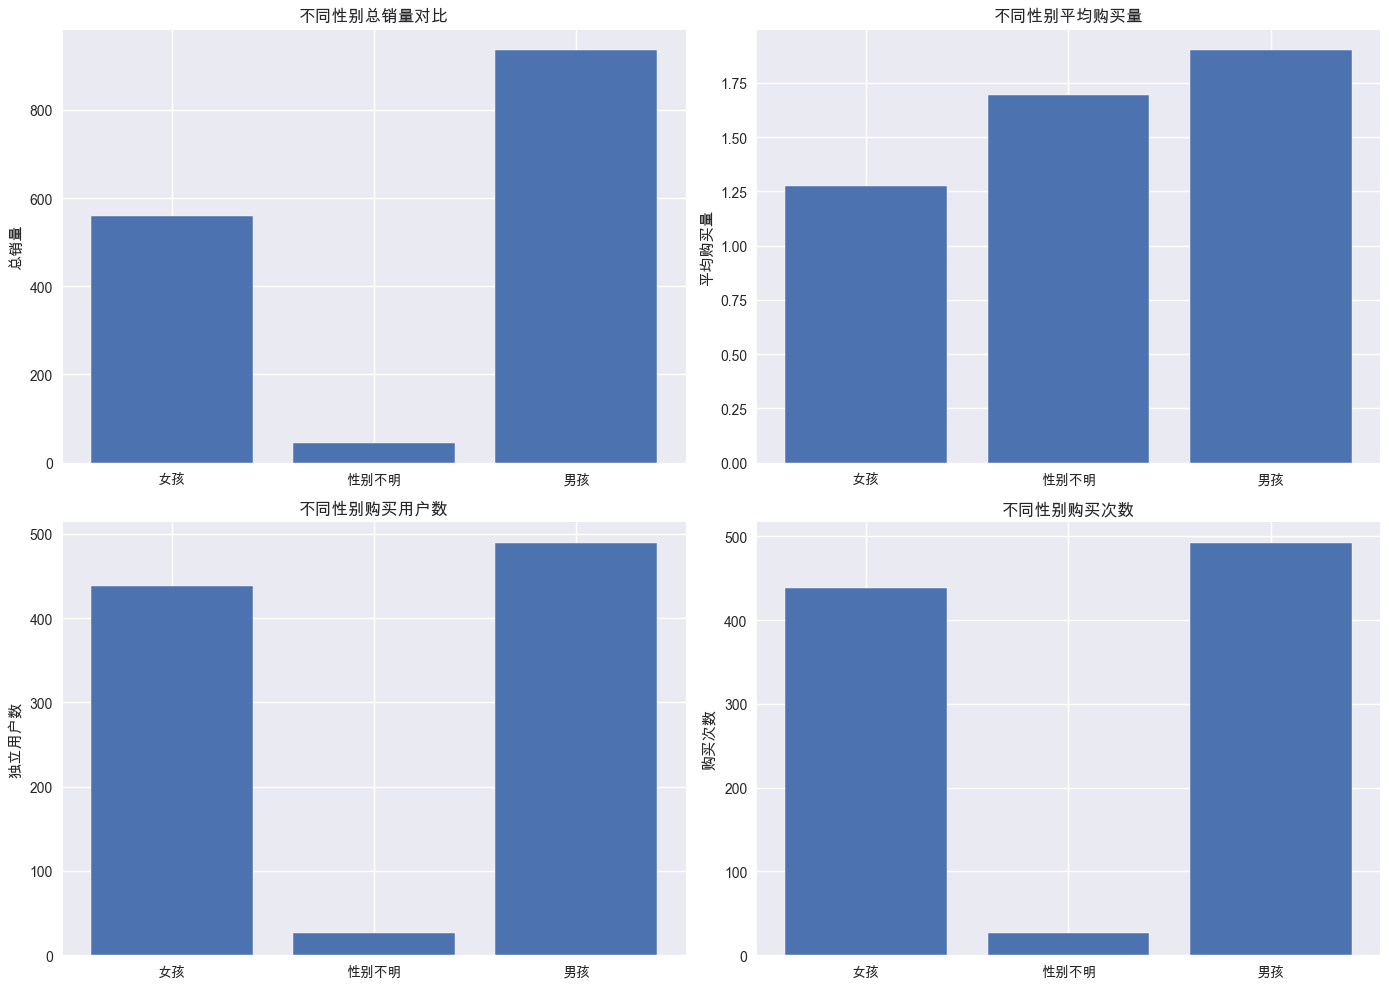


各性别销量最高的5个类目:


,gender_label,category_1,buy_amount
95,女孩,50013636,35
53,女孩,50010558,25
23,女孩,50006602,19
57,女孩,50011993,18
94,女孩,50013207,18
187,性别不明,50012437,15
195,性别不明,50018831,4
177,性别不明,50006602,3
185,性别不明,50012245,3
180,性别不明,50008807,2


In [7]:
# 第七步：性别分析
# 合并用户和交易数据
merged_df = pd.merge(trade_df, user_df, on='user_id', how='left')

# 1. 按性别统计销售情况
gender_sales = merged_df.groupby('gender_label').agg({
    'buy_amount': ['sum', 'mean', 'count'],
    'auction_id': 'nunique',
    'user_id': 'nunique'
}).reset_index()

# 扁平化列名
gender_sales.columns = ['gender', 'total_quantity', 'avg_quantity', 'purchase_count', 'unique_orders', 'unique_users']

print("性别维度销售分析:")
display(gender_sales)

# 2. 可视化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 总销量对比
axes[0, 0].bar(gender_sales['gender'], gender_sales['total_quantity'])
axes[0, 0].set_title('不同性别总销量对比', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('总销量')

# 平均购买量
axes[0, 1].bar(gender_sales['gender'], gender_sales['avg_quantity'])
axes[0, 1].set_title('不同性别平均购买量', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('平均购买量')

# 购买用户数
axes[1, 0].bar(gender_sales['gender'], gender_sales['unique_users'])
axes[1, 0].set_title('不同性别购买用户数', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('独立用户数')

# 购买次数
axes[1, 1].bar(gender_sales['gender'], gender_sales['purchase_count'])
axes[1, 1].set_title('不同性别购买次数', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('购买次数')

plt.tight_layout()
plt.show()

# 3. 按性别和类目交叉分析
if 'category_1' in merged_df.columns:
    gender_category = merged_df.groupby(['gender_label', 'category_1']).agg({
        'buy_amount': 'sum'
    }).reset_index()
    
    # 找出每个性别销量最高的类目
    top_by_gender = gender_category.sort_values(['gender_label', 'buy_amount'], ascending=[True, False])
    top_by_gender = top_by_gender.groupby('gender_label').head(5)
    
    print("\n各性别销量最高的5个类目:")
    display(top_by_gender)

RFM分析结果（前10位用户）:


,user_id,recency,frequency,monetary,R_Score,F_Score,M_Score,RFM_Score
0,2356,635,1,1,1,1,1,111
1,2757,666,1,1,1,1,1,111
2,3942,571,1,1,2,1,1,211
3,4468,539,1,1,2,1,1,211
4,7164,86,1,1,4,1,1,411
5,8842,486,1,1,2,1,1,211
6,12646,687,1,1,1,1,1,111
7,25614,106,1,1,4,1,1,411
8,31299,735,1,45,1,1,1,111
9,32325,418,1,1,2,1,1,211


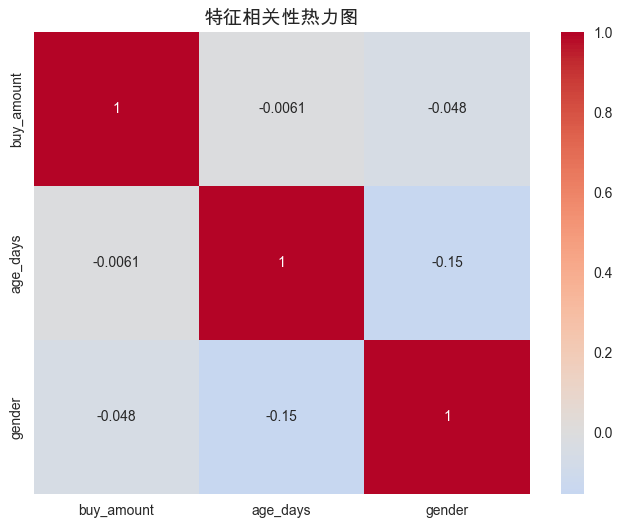

In [8]:
# 第八步：高级分析示例
# 1. RFM分析（客户价值分析）
from datetime import datetime

# 计算R（最近购买时间）、F（购买频率）、M（购买金额/数量）
current_date = merged_df['buy_date'].max()
rfm_df = merged_df.groupby('user_id').agg({
    'buy_date': lambda x: (current_date - x.max()).days,  # R: 最近购买距今天数
    'auction_id': 'count',  # F: 购买次数
    'buy_amount': 'sum'  # M: 总购买量
}).reset_index()

rfm_df.columns = ['user_id', 'recency', 'frequency', 'monetary']


# RFM评分（示例，可根据业务调整）
# 定义安全的分位数切割函数，处理数据中重复值过多的情况
def safe_qcut(series, q, labels, duplicates='drop'):
    try:
        # 尝试使用qcut，如果失败则处理重复值
        result = pd.qcut(series, q=q, labels=labels, duplicates=duplicates)
        return result
    except ValueError as e:
        # 如果qcut失败，说明唯一值数量不足以分成q组或标签数量与分组不匹配
        unique_vals = series.nunique()
        if unique_vals < q:
            # 如果唯一值数量小于所需分组数，则减少分组数
            actual_groups = min(unique_vals, q)
            if actual_groups <= 1:
                # 如果只有一个唯一值，所有值都分配到第一个分组
                return pd.Series([labels[0]] * len(series), index=series.index, dtype=type(labels[0]))
            else:
                # 重新定义标签以适应实际组数
                reduced_labels = labels[:actual_groups] if len(labels) >= actual_groups else list(range(1, actual_groups+1))
                # 使用rank方法分配分组
                ranks = pd.qcut(series.rank(method='first'), q=actual_groups, labels=reduced_labels, duplicates=duplicates)
                return ranks
        else:
            # 如果唯一值数量足够但仍有错误，尝试使用不同的duplicates参数
            try:
                return pd.qcut(series, q=q, labels=labels, duplicates='drop')
            except ValueError:
                # 如果还是失败，使用自定义方法
                # 计算分位数点
                quantiles = np.linspace(0, 1, q + 1)
                bins = series.quantile(quantiles).values
                # 避免由于浮点精度导致的重复边界
                bins = np.unique(bins)
                actual_q = len(bins) - 1
                if actual_q < len(labels):
                    actual_labels = labels[:actual_q]
                else:
                    actual_labels = list(range(1, actual_q + 1))
                
                if actual_q >= 2:
                    return pd.cut(series, bins=bins, labels=actual_labels, include_lowest=True)
                else:
                    # 如果只有一个分组，所有值都分配到第一个分组
                    return pd.Series([labels[0]] * len(series), index=series.index, dtype=type(labels[0]))

rfm_df['R_Score'] = safe_qcut(rfm_df['recency'], 4, labels=[4, 3, 2, 1], duplicates='drop')  # 天数越少分越高
rfm_df['F_Score'] = safe_qcut(rfm_df['frequency'], 4, labels=[1, 2, 3, 4], duplicates='drop')

rfm_df['M_Score'] = safe_qcut(rfm_df['monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop')

rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

print("RFM分析结果（前10位用户）:")
display(rfm_df.head(10))



# 2. 相关性分析
correlation_cols = ['buy_amount', 'age_days', 'gender']
if all(col in merged_df.columns for col in ['buy_amount', 'age_days', 'gender']):
    numeric_df = merged_df[correlation_cols].dropna()
    correlation_matrix = numeric_df.corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('特征相关性热力图', fontsize=14, fontweight='bold')
    plt.show()

In [9]:
# 第九步：保存分析结果
# 保存处理后的数据
merged_df.to_csv('data/processed_data.csv', index=False, encoding='utf-8')

# 保存关键分析结果
analysis_results = {
    'monthly_sales': monthly_sales,
    'category_analysis': category1_sales if 'category_1' in trade_df.columns else None,
    'gender_analysis': gender_sales,
    'rfm_analysis': rfm_df
}

print("分析完成！")
print(f"处理后的数据已保存到: data/processed_data.csv")
print(f"分析数据集大小: {merged_df.shape}")

分析完成！
处理后的数据已保存到: data/processed_data.csv
分析数据集大小: (29971, 15)
